In [1]:
import pandas as pd
import numpy as np
import time
import json

from scipy import stats

import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegressionCV, SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

%matplotlib inline

In [2]:
# load json file containing reddit post data
with open('reddit_data/aita_data.json') as f:
    raw_data = json.load(f)

# get posts as a dataframe
data = pd.json_normalize(raw_data['posts']).drop_duplicates()

data = data[['selftext', 'link_flair_text']]
data = data.rename(columns={'selftext': 'content', 'link_flair_text': 'verdict'})
data['content'] = data['content'].apply(lambda x: x.strip())

# convert verdicts into either 0 (nta), or 1 (yta)
data['verdict'] = data['verdict'].replace({'Asshole' : 1, 'Asshole POO Mode' : 1, 'Not the A-hole' : 0, 'Not the A-hole POO Mode' : 0})

In [3]:
X = data['content']
y = data['verdict']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
# record start time of training and predicting model
start_time = time.perf_counter()

# use same parameters for sparse vectorization as in imdb classifiers
vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(3,6), min_df=5)
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

svd = TruncatedSVD(n_components=300, random_state=42)
X_train_dense = svd.fit_transform(X_train_vectors)
X_test_dense = svd.transform(X_test_vectors)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_dense)
X_test_scaled = scaler.transform(X_test_dense)

# get total time taken to train and scale
end_time = time.perf_counter()
initial_elapsed_time = end_time - start_time

print("Time Taken to Train and Scale Raw Text Data:")
print(str(initial_elapsed_time) + " Seconds")

Time Taken to Train and Scale Raw Text Data:
23.6464751 Seconds


In [6]:
# initialize time and model accuracy lists
times = []
accuracies = []

In [7]:
# C values to try in logistic regression
cs = np.logspace(-4, 3, num=80)

# record start time of training and predicting model
start_time = time.perf_counter()

# logistic regression with augmented stochastic average gradient
logisticcv_clf = LogisticRegressionCV(solver='saga', Cs=cs, max_iter=1000, n_jobs=-1)
logisticcv_clf.fit(X_train_scaled, y_train)
y_pred = logisticcv_clf.predict(X_test_scaled)

# get total time taken to train model and predict
end_time = time.perf_counter()
elapsed_time = end_time - start_time
times.append(elapsed_time + initial_elapsed_time)

accuracies.append(accuracy_score(y_test, y_pred))

print("Tuned Regularization Strength:")
print(logisticcv_clf.C_)

print("\nTotal Time Taken to Train and Evaluate Model:")
print(str(elapsed_time + initial_elapsed_time) + " Seconds")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Tuned Regularization Strength:
[0.00393493]

Total Time Taken to Train and Evaluate Model:
30.228129399999997 Seconds

Confusion Matrix:
[[324 107]
 [169 187]]

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.75      0.70       431
           1       0.64      0.53      0.58       356

    accuracy                           0.65       787
   macro avg       0.65      0.64      0.64       787
weighted avg       0.65      0.65      0.64       787



In [8]:
param_grid = {'C': [.001, .01, .1, 1]}

# record start time of training and predicting model
start_time = time.perf_counter()

# svm using linear kernel
svc_clf = LinearSVC(loss='hinge', max_iter=14000, tol=1e-2)

grid_search = GridSearchCV(svc_clf, param_grid, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
best_svc = grid_search.best_estimator_

y_pred = best_svc.predict(X_test_scaled)

# get total time taken to train model and predict
end_time = time.perf_counter()
elapsed_time = end_time - start_time
times.append(elapsed_time + initial_elapsed_time)

accuracies.append(accuracy_score(y_test, y_pred))

print("Tuned Regularization Strength:")
print(grid_search.best_params_)

print("\nTotal Time Taken to Train and Evaluate Model:")
print(str(elapsed_time + initial_elapsed_time) + " Seconds")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Tuned Regularization Strength:
{'C': 0.001}

Total Time Taken to Train and Evaluate Model:
31.6094082 Seconds

Confusion Matrix:
[[307 124]
 [162 194]]

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.71      0.68       431
           1       0.61      0.54      0.58       356

    accuracy                           0.64       787
   macro avg       0.63      0.63      0.63       787
weighted avg       0.63      0.64      0.63       787



In [9]:
param_grid = {'alpha': [.00001, .0001, .001, .01, .1, 1]}

# record start time of training and predicting model
start_time = time.perf_counter()

# svm with stochastic gradient descent training
sgdlog_clf = SGDClassifier(loss='hinge', n_jobs=-1)

grid_search_2 = GridSearchCV(sgdlog_clf, param_grid, scoring='accuracy', n_jobs=-1)
grid_search_2.fit(X_train_scaled, y_train)
best_sgdlog = grid_search_2.best_estimator_

y_pred = best_sgdlog.predict(X_test_scaled)

# get total time taken to train model and predict
end_time = time.perf_counter()
elapsed_time = end_time - start_time
times.append(elapsed_time + initial_elapsed_time)

accuracies.append(accuracy_score(y_test, y_pred))

print("Tuned Alpha Value:")
print(grid_search_2.best_params_)

print("\nTotal Time Taken to Train and Evaluate Model:")
print(str(elapsed_time + initial_elapsed_time) + " Seconds")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Tuned Alpha Value:
{'alpha': 0.01}

Total Time Taken to Train and Evaluate Model:
24.32230460000002 Seconds

Confusion Matrix:
[[297 134]
 [143 213]]

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.69      0.68       431
           1       0.61      0.60      0.61       356

    accuracy                           0.65       787
   macro avg       0.64      0.64      0.64       787
weighted avg       0.65      0.65      0.65       787



In [10]:
param_grid = {'n_estimators': [400, 500, 600]}

# record start time of training and predicting model
start_time = time.perf_counter()

# random forest classifier
forest_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

grid_search_3 = GridSearchCV(forest_clf, param_grid, scoring='accuracy', n_jobs=-1)
grid_search_3.fit(X_train_scaled, y_train)
best_forest = grid_search_3.best_estimator_

y_pred = best_forest.predict(X_test_scaled)

# get total time taken to train model and predict
end_time = time.perf_counter()
elapsed_time = end_time - start_time
times.append(elapsed_time + initial_elapsed_time)

accuracies.append(accuracy_score(y_test, y_pred))

print("Tuned Number of Trees in Forest:")
print(grid_search_3.best_params_)

print("\nTotal Time Taken to Train and Evaluate Model:")
print(str(elapsed_time + initial_elapsed_time) + " Seconds")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Tuned Number of Trees in Forest:
{'n_estimators': 500}

Total Time Taken to Train and Evaluate Model:
56.154303 Seconds

Confusion Matrix:
[[425   6]
 [225 131]]

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.99      0.79       431
           1       0.96      0.37      0.53       356

    accuracy                           0.71       787
   macro avg       0.81      0.68      0.66       787
weighted avg       0.79      0.71      0.67       787



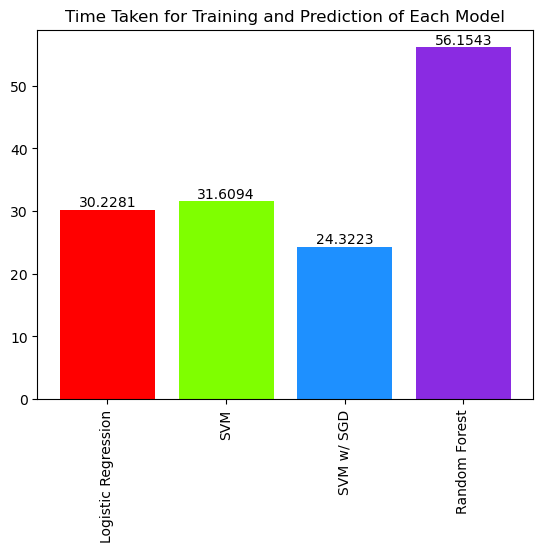

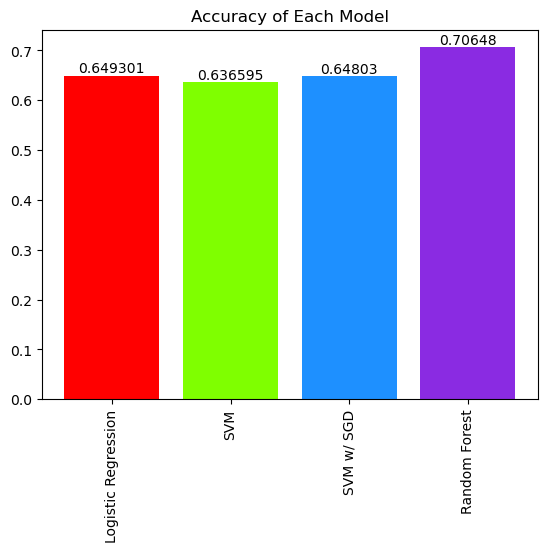

In [11]:
models = ['Logistic Regression', 'SVM', 'SVM w/ SGD', 'Random Forest']
colors = ['r', 'chartreuse', 'dodgerblue', 'blueviolet']

fig, ax = plt.subplots()
bars = ax.bar(models, times, color=colors)
ax.bar_label(bars)
plt.title("Time Taken for Training and Prediction of Each Model")
plt.xticks(rotation=90)
plt.show()

fig, ax = plt.subplots()
bars = ax.bar(models, accuracies, color=colors)
ax.bar_label(bars)
plt.title("Accuracy of Each Model")
plt.xticks(rotation=90)
plt.show()